In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


# Imports the methods needed to abstract classes into tables
from sqlalchemy.ext.declarative import declarative_base

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.ext.declarative import declarative_base

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()



In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.metadata.create_all(engine)
# reflect the tables
Base.prepare(autoload_with=engine)


In [15]:
# View all of the classes that automap found
display(Base.classes.keys())
for key in Base.classes.keys():
    print(f'Table: {key}')
    print(f'Columns: {Base.classes[key].__table__.columns}')

['measurement', 'station']

Table: measurement
Columns: ImmutableColumnCollection(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs)
Table: station
Columns: ImmutableColumnCollection(station.id, station.station, station.name, station.latitude, station.longitude, station.elevation)


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [78]:
# Find the most recent date in the data set.

from datetime import datetime, timedelta

latest_measurement = session.query(Measurement).order_by(Measurement.date.desc()).first()
latest_measurement.date
latest_measurement_date = datetime.strptime(latest_measurement.date, '%Y-%m-%d')
latest_measurement.date


'2017-08-23'

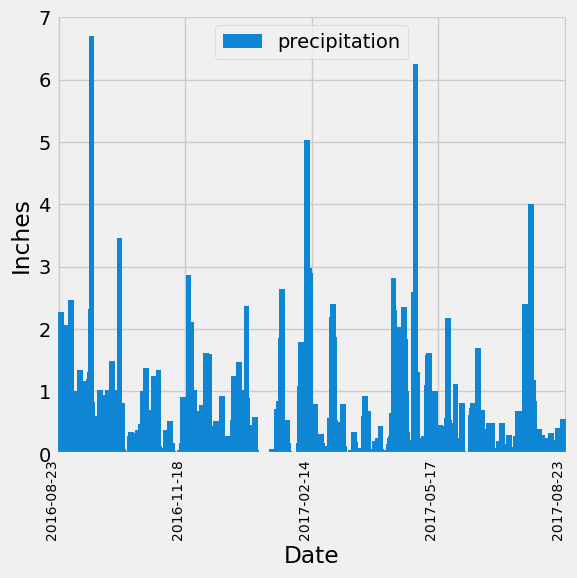

In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Perform a query to retrieve the data and precipitation scores
twelve_months_ago = latest_measurement_date - timedelta(days=366)
measurements_last_12_months = (
    session.query(Measurement)
    .filter(Measurement.date >= twelve_months_ago)
    .order_by(Measurement.date.desc())
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame([
    {
        "id": measurement.id,
        "station": measurement.station,
        "date": measurement.date,
        "precipitation": measurement.prcp,
        "tobs": measurement.tobs
    }
    for measurement in measurements_last_12_months
])

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date', ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(kind='bar', x='date', y='precipitation', width=25, color='#0E86D4', alpha=1, figsize=(6, 6))
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
slice_size = max(len(df) // 4, 1)
tick_labels = df['date'].iloc[::slice_size].dt.strftime('%Y-%m-%d')
ax.set_xticks(ax.get_xticks()[::slice_size])
ax.set_xticklabels(tick_labels, rotation=90, ha='right', fontsize=10)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc='upper center')
plt.tight_layout()
plt.show()

In [89]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()
display(summary_stats.to_frame())

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [92]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.id).count()
station_count

9

In [100]:
# Perform a join and count query
station_measurements = (
    session.query(Station, func.count(Measurement.id).label('measurement_count'))
    .select_from(Station)
    .join(Measurement, Station.id == Measurement.station)
    .group_by(Station)
    .all()
)

print(station_measurements)

# Print the results
for station, measurement_count in station_measurements:
    print(f"Station ID: {station.id}, Name: {station.name}, Measurement Count: {measurement_count}")

[]


In [102]:
# Perform a join and count query using select_from
query = (
    session.query(Station, func.count(Measurement.id).label('measurement_count'))
    .select_from(Station)
    .join(Measurement, Station.id == Measurement.station)
    .group_by(Station)
    .order_by(func.count(Measurement.id).desc())
)

# Print the generated SQL statement for debugging
print(query)

# Execute the query and print the results
station_measurements = query.all()
print(station_measurements)

SELECT station.id AS station_id, station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation, count(measurement.id) AS measurement_count 
FROM station JOIN measurement ON station.id = measurement.station GROUP BY station.id, station.station, station.name, station.latitude, station.longitude, station.elevation ORDER BY count(measurement.id) DESC
[]


In [108]:
session.query(Measurement).order_by('date').first().station

'USC00519397'

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

for station, count in results:
    print(f"Station: {station}, Count: {count}")

most_active_station = results[0][0]

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).one()

print(result)

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

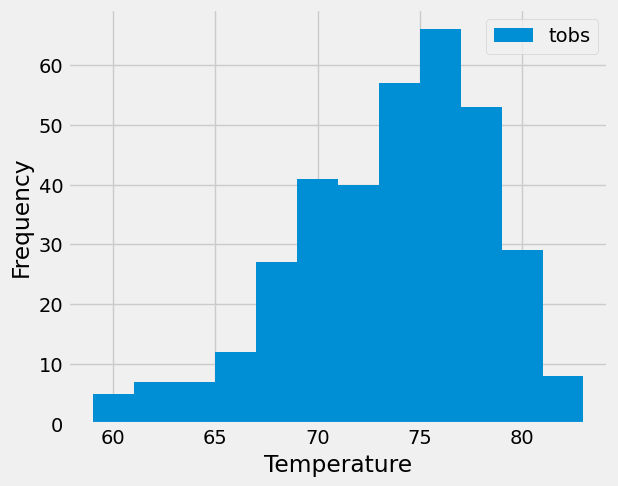

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostactive_measurements_last_12_months = (
    session.query(Measurement)
    .filter(Measurement.date >= twelve_months_ago)
    .filter(Measurement.station == most_active_station)
    .order_by(Measurement.date.desc())
    .all()
)

tobs_values = [measurement.tobs for measurement in mostactive_measurements_last_12_months]

plt.hist(tobs_values, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.title('Temperature Observations')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()